## Example: The Insurance Problem

When faced with an insurance decision, the decision maker must choose between two options:
* __Scenario A (left)__: In this situation, an accident can occur with a probability of `p`. The accident may cause damages of `d USD` to an object owned by the decision maker, such as a car or house, which will reduce the decision maker's wealth to `W-d USD`. However, there is also a chance of `1-p` that nothing will happen, leaving the decision maker's wealth at `W USD`.
* __Scenario B (right)__: In this scenario, the decision maker has purchased an insurance policy for `r USD` to cover all damages in the event of an accident. In the case of an accident, the decision maker will be left with a wealth of `W-r USD`. However, if no accident occurs, the decision maker will still have a wealth of `W-r USD`.

![ALT_TEXT_FOR_SCREEN_READERS](figs/Fig-InsuranceProblem-Schematic.svg)

### Learning Objectives
* We will examine the insurance problem and demonstrate that, under specific conditions, the expected value of `Scenario A (no insurance)` is consistently higher than `Scenario B (no insurance)`. This means that choosing to forego insurance is the suggested decision based on expected value. However, if a decision maker is risk-averse and uses the `expected utility` decision framework, they would always choose to purchase insurance under the same conditions.
* Lastly, we will calculate the certainty equivalent and the risk premium for the insurance problem while determining the maximum amount a risk-averse decision-maker would be willing to pay for the premium to compensate for the risk.

### Setup

In [1]:
using Pkg
Pkg.add(path="https://github.com/varnerlab/VLDecisionsPackage.jl.git")

    Updating git-repo `https://github.com/varnerlab/VLDecisionsPackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-5760-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5760-Examples-F23/Manifest.toml`


In [2]:
include("Include.jl");

#### Constants
Let's set some constants that we'll use throughout the example. First, assume that the ratio of the premium paid to the insurance company to the potential damage that could occur is defined as:
$$
\frac{r}{d} \equiv \alpha
$$
Further, we assume the level of damage that could occur is defined as some fraction $\beta$ of the value of the object (which we take as the `W` in the problem):
$$
\frac{d}{W} \equiv \beta
$$
Finally, we'll set values for the variables `number_of_trials`, the number of random trials we perform, and `number_of_points`, which is used in the plotting. 

In [3]:
α = 0.11;
β = 0.90;
W = 12448.00; # the cost of the macPro server
d = β*W
r = α*d;
number_of_trials = 50000;
number_of_points = 100;

### Expected Value Simulation
To compute the expected value of each scenario, we sample a [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) with probability `p` of an accident occurring. We store an instance of the `Bernoulli` distribution exported from the [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) package in the variable `d₁`:

In [4]:
p₁ = 0.1; # probability that of entering the damage state
d₁ = Bernoulli(p₁);

We use a `for` loop to take `number_of_trials` samples from the `Bernoulli` distribution, and save the results in the `expected_value_simulation_archive` variable, which is a `number_of_trials` $\times$ `2` array. During each trial, we:
- Generate a sample from the `Bernoulli` distribution and store it in the `future_state` variable.
- If `future_state` is equal to 1, indicating an accident state, we calculate the values for `Scenario A (no insurance)` (column 1) and `Scenario B (insurance)` (column 2) for the accident state.
- If `future_state` is equal to 0, indicating a normal state, we calculate the values for `Scenario A (no insurance)` (column 1) and `Scenario B (insurance)` (column 2) for the normal state.

In [5]:
expected_value_simulation_archive = Array{Float64,2}(undef, number_of_trials, 2);
for i ∈ 1:number_of_trials
    
    # role a random future state -
    future_state = rand(d₁);
    if (future_state == 1)
        expected_value_simulation_archive[i,1] = W - d
        expected_value_simulation_archive[i,2] = W - r
    else
        expected_value_simulation_archive[i,1] = W
        expected_value_simulation_archive[i,2] = W - r
    end
end

#### Decision: Numerical expected value
Finally, we compute the expected value for each the scenarios using the `mean(...)` function from the [Statistics.jl](https://docs.julialang.org/en/v1/stdlib/Statistics/) package:

In [6]:
μ₁ = mean(expected_value_simulation_archive,dims=1) |> vec;
if (μ₁[1] ≥ μ₁[2])
    println("𝔼(A) = $(μ₁[1]) ≥ 𝔼(B) = $(μ₁[2]) => Don't purchase insurance")
else
    println("𝔼(A) = $(μ₁[1]) < 𝔼(B) = $(μ₁[2]) => Purchase insurance")
end

𝔼(A) = 11333.953792 ≥ 𝔼(B) = 11215.648000000028 => Don't purchase insurance


##### Check: Analytical expected value
We check the sampling algorithm above by computing the analytical value of the expectation for each scenario. The expected value for `Scenario A (no insurance)` is given by:

$$
\begin{equation}
\mathbb{E}(A) = p\cdot\left(W-d\right)+(1-p)\cdot{W}
\end{equation}
$$

while the expected value for `Scenario B (insurance)` is given by $\mathbb{E}(B) = W - r$.

In [7]:
expected_value_case_A = p₁*(W - d)+(1-p₁)*W;
expected_value_case_B = (W - r)
if (expected_value_case_A ≥ expected_value_case_B)
    println("𝔼(A) = $(expected_value_case_A) ≥ 𝔼(B) = $(expected_value_case_B) => Don't purchase insurance")
else
    println("𝔼(A) = $(expected_value_case_A) < 𝔼(B) = $(expected_value_case_A) => Purchase insurance")
end

𝔼(A) = 11327.68 ≥ 𝔼(B) = 11215.648 => Don't purchase insurance


### Expected Utility Simulation
To compute the expected utility of each scenario, we use the instance of the `Bernoulli` distribution exported from the [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) package that we constructed above, a similar sampling algorithm and a utility function. Let's begin by defining a utility function $U(x,s)$ and the inverse of the utility function $IU(x,s)$. Finally, we specify a value for the risk-aversion parameter $\tau$:

In [8]:
τ = 0.10
U(x,s) = x^(s)
IU(x,s) = x^(1/s);

We use a `for` loop to take `number_of_trials` samples from the `Bernoulli` distribution, and save the results in the `expected_utility_simulation_archive` variable, which is a `number_of_trials` $\times$ `2` array. During each trial, we:
- Generate a sample from the `Bernoulli` distribution and store it in the `future_state` variable.
- If `future_state` is equal to 1, indicating an accident state, we calculate the utility for `Scenario A (no insurance)` (column 1) and `Scenario B (insurance)` (column 2) for the accident state.
- If `future_state` is equal to 0, indicating a normal state, we calculate the utility for `Scenario A (no insurance)` (column 1) and `Scenario B (insurance)` (column 2) for the normal state.

In [9]:
expected_utility_simulation_archive = Array{Float64,2}(undef, number_of_trials, 2);
for i ∈ 1:number_of_trials
    
    # role a random future state -
    future_state = rand(d₁);
    if (future_state == 1)
        expected_utility_simulation_archive[i,1] = U(W - d, τ)
        expected_utility_simulation_archive[i,2] = U(W - r, τ)
    else
        expected_utility_simulation_archive[i,1] = U(W, τ)
        expected_utility_simulation_archive[i,2] = U(W - r, τ)
    end
end

Finally, we compute the expected utility for each the scenarios using the `mean(...)` function from the [Statistics.jl](https://docs.julialang.org/en/v1/stdlib/Statistics/) package:

In [10]:
μ₂ = mean(expected_utility_simulation_archive,dims=1) |> vec;
if (μ₂[1] ≥ μ₂[2])
    
    println("𝔼𝕌(A) = $(μ₂[1]) ≥ 𝔼𝕌(B) = $(μ₂[2]) => Don't purchase insurance")
else
    println("𝔼𝕌(A) = $(μ₂[1]) < 𝔼𝕌(B) = $(μ₂[2]) => Purchase insurance")
end

𝔼𝕌(A) = 2.515187290052983 < 𝔼𝕌(B) = 2.540869950288979 => Purchase insurance


##### Check: Analytical expected utility value
We check the sampling algorithm above by computing the analytical value of the expected utility for each scenario. The expected utility for `Scenario A (no insurance)` is given by:

$$
\begin{equation}
\mathbb{EU}(A) = p\cdot{U}\left(W-d, \tau\right)+(1-p)\cdot{U(W, \tau)}
\end{equation}
$$

while the expected value for `Scenario B (insurance)` is given by $\mathbb{EU}(B) = U(W - r, \tau)$.

In [11]:
expected_utility_case_A = p₁*U(W - d, τ)+(1-p₁)*U(W, τ);
expected_utility_case_B = U(W - r, τ)
if (expected_utility_case_A ≥ expected_utility_case_B)
    
    println("𝔼𝕌(A) = $(expected_utility_case_A) ≥ 𝔼𝕌(B) = $(expected_utility_case_B) => Don't purchase insurance")
else
    println("𝔼𝕌(A) = $(expected_utility_case_A) < 𝔼𝕌(B) = $(expected_utility_case_B) => Purchase insurance")
end

𝔼𝕌(A) = 2.5146909120960492 < 𝔼𝕌(B) = 2.5408699502889687 => Purchase insurance


### Computing the Certainty Equivalent and the Risk Premium
The certainty equivalent (CE) is a guaranteed level of wealth that provides the same utility as the expected utility of a risky scenario. For example, in the insurance problem, the certainty equivalent is given by:

$$
\begin{equation}
\text{CE} = \mathbb{E}(A) - R_{P}
\end{equation}
$$

where $\mathbb{E}(A)$ denotes the expected value of scenario $A$ (no insurance), and $R_{P}$ represents the risk premium, the 
amount that a risk-averse decision-maker will pay to avoid taking a risk. We have already computed the expected value $\mathbb{E}(A)$.
However, to compute the risk premium, we need to know the amount of money we would be willing to give up to eliminate the risk.

#### Implementation
First, let's compute the wealth `W` associated with the expected value of the no insurance case $\mathbb{EU}(\text{A})$ by inverting the utility function $W = \Bigl(\mathbb{EU}(\text{A})\Bigr)^{1/\tau}$:

In [45]:
Ŵ = IU(expected_utility_case_A, τ);
println("The wealth value of 𝔼𝕌(A) is given by $(round(Ŵ, digits=3)) USD")

The wealth value of 𝔼𝕌(A) is given by 10112.211 USD


Next, let's compute the indifferent utility value. To do this, we compute our position on the expected utility line by interpolating the wealth value:

In [44]:
L₁ = W - d
L₂ = W
θ̂ = (Ŵ - L₁)/(L₂ - L₁)
U_indifferent = θ̂*U(W,τ) + (1-θ̂)*U(W-d,τ)
println("The utility of having $(round(Ŵ, digits=3)) USD is U_indiff = $(U_indifferent)")

The utility of having 10112.211 USD is U_indiff = 2.4573999082276425


Finally, let's compute the certainty equivalent (the wealth value associated with our indifference):

In [47]:
CE = IU(U_indifferent,τ);
println("The certainty equivalent (CE) = $(CE) USD")

The certainty equivalent (CE) = 8030.791990733266 USD


#### Visualize

In [53]:
utility_array = Array{Float64,2}(undef,number_of_points,2);
WA = range(0.8*(W-d), stop = 1.2*W, length = number_of_points) |> collect;
for i ∈ 1:number_of_points
    utility_array[i,1] = WA[i];
    utility_array[i,2] = U(WA[i],τ);
end

tie_line = Array{Float64,2}(undef,number_of_points,2);
θ = range(0,1,length = number_of_points) |> collect;
for i ∈ 1:number_of_points
    θᵢ = θ[i];
    tie_line[i,1] = θᵢ*W + (1-θᵢ)*(W-d)
    tie_line[i,2] = θᵢ*U(W,τ) + (1-θᵢ)*U(W-d,τ)
end

VLINE₁ = zeros(number_of_points, 2);
VLINE₁[:,1] .= IU(expected_utility_case_A,τ)*ones(number_of_points);
VLINE₁[:,2] .= range(minimum(utility_array[:,2]), maximum(utility_array[:,2]), length=number_of_points) |> collect;

point_A = [IU(expected_utility_case_A, τ), expected_utility_case_A];

B₁ = W - d
B₂ = W
γ = (IU(expected_utility_case_A,τ) - B₁)/(B₂ - B₁)
point_B = [IU(expected_utility_case_A,τ), γ*U(W,τ) + (1-γ)*U(W-d,τ)];

point_C = [IU(point_B[2],τ), point_B[2]];
CE = point_C[1];

VLINE₂ = zeros(number_of_points, 2);
VLINE₂[:,1] .= point_C[1]*ones(number_of_points);
VLINE₂[:,2] .= range(minimum(utility_array[:,2]), maximum(utility_array[:,2]), length=number_of_points) |> collect;

HLINE = zeros(number_of_points, 2);
HLINE[:,1] .= range(0.8*(W-d), 1.2*(W), length=number_of_points) |> collect;
HLINE[:,2] .= point_B[2]*ones(number_of_points);

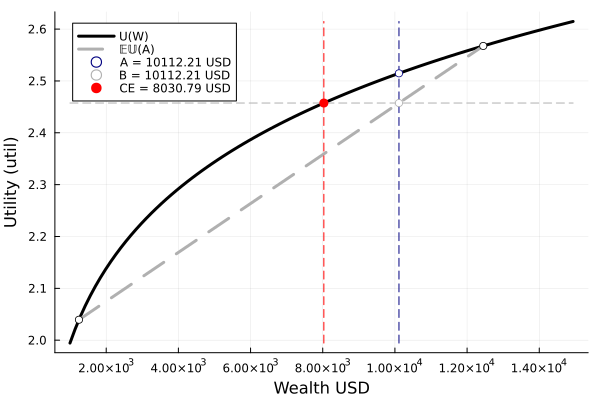

In [55]:
plot(utility_array[:,1],utility_array[:,2], label="U(W)", xlabel="Wealth USD", ylabel = "Utility (util)", lw=3, c=:black)
plot!(tie_line[:,1],tie_line[:,2], label="𝔼𝕌(A)", lw=3, c=:gray69, ls=:dash)
plot!(VLINE₁[:,1], VLINE₁[:,2], label="", c=:navyblue, ls=:dash)
plot!(VLINE₂[:,1], VLINE₂[:,2], label="", c=:red, ls=:dash)
plot!(HLINE[:,1], HLINE[:,2], label="", c=:gray69, ls=:dash, lw=1)
scatter!([W-d],[U(W-d,τ)], label="", msc=:black, mc=:white)
scatter!([W],[U(W,τ)], label="", msc=:black, mc=:white)
scatter!([point_A[1]],[point_A[2]], label="A = $(round(point_A[1],digits=2)) USD", msc=:navyblue, mc=:white)
scatter!([point_B[1]],[point_B[2]],label="B = $(round(point_B[1],digits=2)) USD", msc=:gray69, mc=:white)
scatter!([point_C[1]],[point_C[2]],label="CE = $(round(point_C[1],digits=2)) USD", msc=:red, mc=:red, ms=5)

#### Computing the Risk Premium (RP)

In [38]:
RP = Ŵ - CE

2081.419006999634

The `maximum insurance premium` this decision maker is willing to pay is the risk premium `RP` plus the actuarially fair premium $p\cdot{d}$ (the probability of accident $\times$ the damage of an accident):

In [39]:
r̄ = p₁*d + RP

3201.739006999634